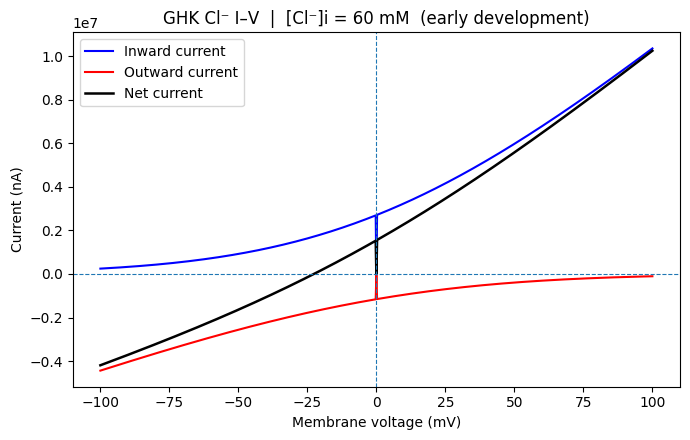


[Cl⁻]i = 60.0 mM (early development):
  At Vm = -68.00 mV:
    Inward current (I_in):   585726.2385 nA
    Outward current (I_out): -3197013.3396 nA
    Net current (I_tot):     -2611287.1010 nA


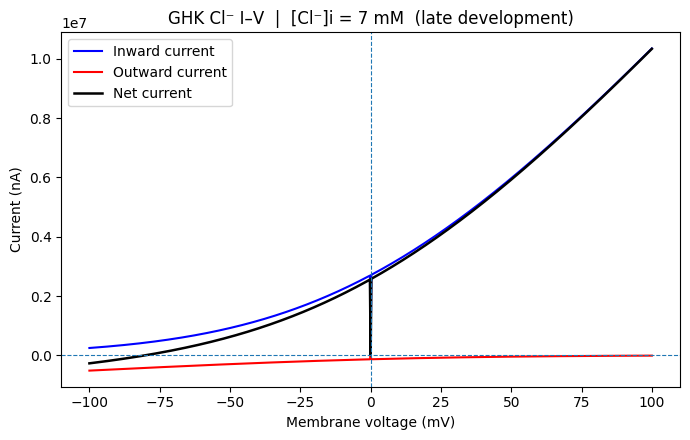


[Cl⁻]i = 7.0 mM (late development):
  At Vm = -68.00 mV:
    Inward current (I_in):   585726.2385 nA
    Outward current (I_out): -372984.8896 nA
    Net current (I_tot):     212741.3489 nA


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ----------------------------- Constants -------------------------------------
R = 8.314            # J/(mol·K)
T = 310.15           # K (37 °C)
F = 96485.33212      # C/mol
Z_CL = -1            # valence of chloride
P = 2e-7             # "permeability" scale in A/M (per assignment)

# ----------------------------- Core math -------------------------------------
def ghk_cl_current_components(Vm_volts: np.ndarray, Ci_M: float, Co_M: float):
    """
    Compute inward, outward, and net Cl- currents via the GHK current equation.
    Sign convention: positive current = outward (electrophysiology convention).

    GHK (total) for a single ion:
        I = P * (z^2 * F^2 * Vm / (R*T)) * (Ci - Co * exp(-z F Vm / (R T))) / (1 - exp(-z F Vm / (R T)))

    We also return a stable decomposition into:
        I_out =  P * (...) * ( Ci / (1 - exp(-x)) )
        I_in  = -P * (...) * ( Co * exp(-x) / (1 - exp(-x)) )
    where x = z F Vm / (R T), so that I_tot = I_out + I_in

    We handle Vm ≈ 0 using the L'Hôpital limit:
        I_tot ≈ P * (z^2 F^2 / (R T)) * (Ci - Co) * Vm
        I_out ≈ P * (z^2 F^2 / (R T)) * (Ci) * Vm
        I_in  ≈ -P * (z^2 F^2 / (R T)) * (Co) * Vm
    """
    Vm = np.asarray(Vm_volts, dtype=float)
    z = Z_CL

    x = z * F * Vm / (R * T)
    ex = np.exp(-x)
    denom = 1 - ex
    pref = P * (z**2) * (F**2) * Vm / (R * T)

    I_tot = np.empty_like(Vm)
    I_in  = np.empty_like(Vm)   # inward contribution (associated with Co term)
    I_out = np.empty_like(Vm)   # outward contribution (associated with Ci term)

    nz = np.abs(Vm) > 1e-12
    z0 = ~nz

    # Vm ≠ 0: use standard expressions
    I_tot[nz] = pref[nz] * (Ci_M - Co_M * ex[nz]) / denom[nz]
    I_out[nz] =  pref[nz] * (Ci_M / denom[nz])
    I_in[nz]  = -pref[nz] * (Co_M * ex[nz] / denom[nz])

    # Vm ~ 0: L'Hôpital limit (first-order in Vm)
    if np.any(z0):
        slope = P * (z**2) * (F**2) / (R * T)  # A/(M·V)
        I_tot[z0] = slope * (Ci_M - Co_M) * Vm[z0]
        I_out[z0] = slope * (Ci_M) * Vm[z0]
        I_in[z0]  = -slope * (Co_M) * Vm[z0]

    return I_in, I_out, I_tot


# ----------------------------- Plotting --------------------------------------
@dataclass
class Condition:
    Ci_mM: float
    Co_mM: float = 140.0
    label: str = ""

def plot_condition(cond: Condition):
    Vm_mV = np.linspace(-100.0, 100.0, 801)  # step 0.25 mV
    Vm_V  = Vm_mV / 1000.0

    Ci_M = cond.Ci_mM / 1000.0
    Co_M = cond.Co_mM / 1000.0

    I_in, I_out, I_tot = ghk_cl_current_components(Vm_V, Ci_M, Co_M)

    # Convert A → nA for plotting
    I_in_nA  = I_in  * 1e9
    I_out_nA = I_out * 1e9
    I_tot_nA = I_tot * 1e9

    plt.figure(figsize=(7,4.5))
    plt.plot(Vm_mV, I_in_nA,  label='Inward current',color='blue')
    plt.plot(Vm_mV, I_out_nA, label='Outward current',color='red')
    plt.plot(Vm_mV, I_tot_nA, label='Net current', linewidth=1.8,color='black')
    plt.axhline(0, ls='--', lw=0.8)
    plt.axvline(0, ls='--', lw=0.8)
    title = f"GHK Cl⁻ I–V  |  [Cl⁻]i = {cond.Ci_mM:.0f} mM"
    if cond.label:
        title += f"  ({cond.label})"
    plt.title(title)
    plt.xlabel("Membrane voltage (mV)")
    plt.ylabel("Current (nA)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    # No file saving, just show the plot
    return Vm_mV, I_in, I_out, I_tot


# ----------------------------- Main ------------------------------------------
if __name__ == "__main__":
    conds = [
        Condition(Ci_mM=60.0, label="early development"),
        Condition(Ci_mM=7.0,  label="late development"),
    ]

    for cond in conds:
        Vm_mV, I_in, I_out, I_tot = plot_condition(cond)
        # Print the value of the IV relationship at -68 mV
        Vm_query = -68.0
        # Find the index closest to -68 mV
        idx = (np.abs(Vm_mV - Vm_query)).argmin()
        print(f"\n[Cl⁻]i = {cond.Ci_mM:.1f} mM ({cond.label}):")
        print(f"  At Vm = {Vm_mV[idx]:.2f} mV:")
        print(f"    Inward current (I_in):   {I_in[idx]*1e9:.4f} nA")
        print(f"    Outward current (I_out): {I_out[idx]*1e9:.4f} nA")
        print(f"    Net current (I_tot):     {I_tot[idx]*1e9:.4f} nA")
        # No CSV saving, just show the plots


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
R = 8.314  # J/(mol·K)
T = 310.15  # K (37°C)
F = 96485  # C/mol
P_Cl = 2e-7  # amps/M (as permeability, but GHK uses m/s, so we treat as arbitrary units for plotting)
z_Cl = -1  # valence of Cl-

# Extracellular Cl- concentration (mM)
Cl_o = 140

# Intracellular Cl- concentrations (mM) for two conditions
Cl_i_1 = 60
Cl_i_2 = 7

# Membrane potentials (Vm) from -100 mV to +100 mV, excluding 0 to avoid division by zero
Vm = np.linspace(-100, 100, 201)
Vm = Vm[Vm != 0]  # Remove 0 mV
from IPython.display import display, Math

# Print the GHK equation for anions (Cl-) in LaTeX format
ghk_eq = r"""
I_{Cl^-} = P_{Cl} \cdot z^2 F^2 \frac{V_m}{RT} \cdot \frac{[Cl^-]_{out} - [Cl^-]_{in} \cdot e^{zFV_m/RT}}{1 - e^{zFV_m/RT}}
"""

display(Math(ghk_eq))



<IPython.core.display.Math object>

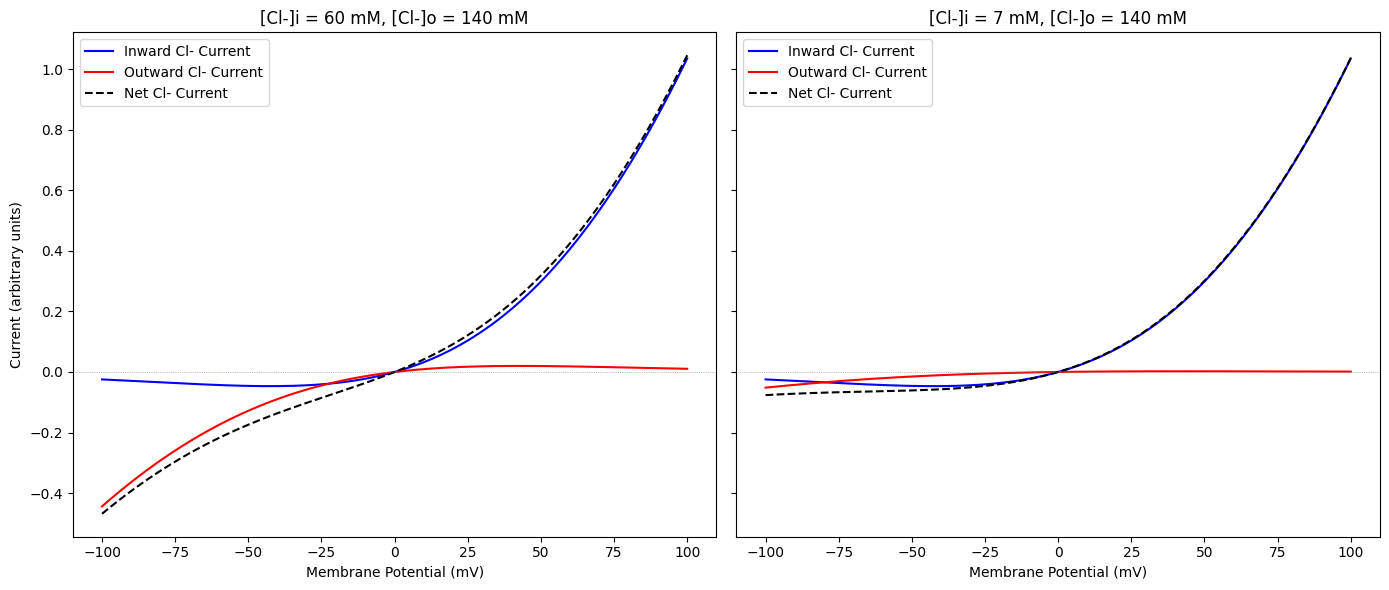

In [15]:
def ghk_current(Vm_mV, Cl_i, Cl_o, P_Cl, z=z_Cl):
    Vm_V = Vm_mV / 1000  # Convert mV to V
    # GHK current equation for anions (Cl-)
    num = P_Cl * z**2 * F**2 * Vm_V / (R * T)
    exp_term = z * F * Vm_V / (R * T)
    # Inward: Cl- moving into cell (from outside to inside)
    I_in=num*(Cl_o*Vm_V/(1-np.exp(exp_term)))
    I_out=-num*(Cl_i*Vm_V/(1-np.exp(-exp_term)))
    I_net=I_in+I_out
    return I_in, I_out, I_net


# Calculate currents for both conditions
I_in_1, I_out_1, I_net_1 = ghk_current(Vm, Cl_i_1, Cl_o, P_Cl)
I_in_2, I_out_2, I_net_2 = ghk_current(Vm, Cl_i_2, Cl_o, P_Cl)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Condition 1: 60 mM [Cl-]i
axs[0].plot(Vm, I_in_1, label='Inward Cl- Current', color='blue')
axs[0].plot(Vm, I_out_1, label='Outward Cl- Current', color='red')
axs[0].plot(Vm, I_net_1, label='Net Cl- Current', color='black', linestyle='--')
axs[0].set_title('[Cl-]i = 60 mM, [Cl-]o = 140 mM')
axs[0].set_xlabel('Membrane Potential (mV)')
axs[0].set_ylabel('Current (arbitrary units)')
axs[0].legend()
axs[0].axhline(0, color='gray', linewidth=0.5, linestyle=':')

# Condition 2: 7 mM [Cl-]i
axs[1].plot(Vm, I_in_2, label='Inward Cl- Current', color='blue')
axs[1].plot(Vm, I_out_2, label='Outward Cl- Current', color='red')
axs[1].plot(Vm, I_net_2, label='Net Cl- Current', color='black', linestyle='--')
axs[1].set_title('[Cl-]i = 7 mM, [Cl-]o = 140 mM')
axs[1].set_xlabel('Membrane Potential (mV)')
axs[1].legend()
axs[1].axhline(0, color='gray', linewidth=0.5, linestyle=':')

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
summary_path=r"C:\Users\abdul\Downloads\CPPA_v1.0_Cell_line_perturbed_responses_delta-p_TreatmentSummary\CPPA_v1.0_Cell_line_perturbed_responses_delta-p_TreatmentSummary"

import os

# List all .tsv files in the summary_path directory
tsv_files = [os.path.join(summary_path, f) for f in os.listdir(summary_path) if f.endswith('.tsv')]


Could not read C:\Users\abdul\Downloads\CPPA_v1.0_Cell_line_perturbed_responses_delta-p_TreatmentSummary\CPPA_v1.0_Cell_line_perturbed_responses_delta-p_TreatmentSummary\CPPA_v1.0_Cell_line_perturbed_responses_delta-p_TreatmentSummary_set68.tsv: 'utf-8' codec can't decode byte 0xb5 in position 211: invalid start byte


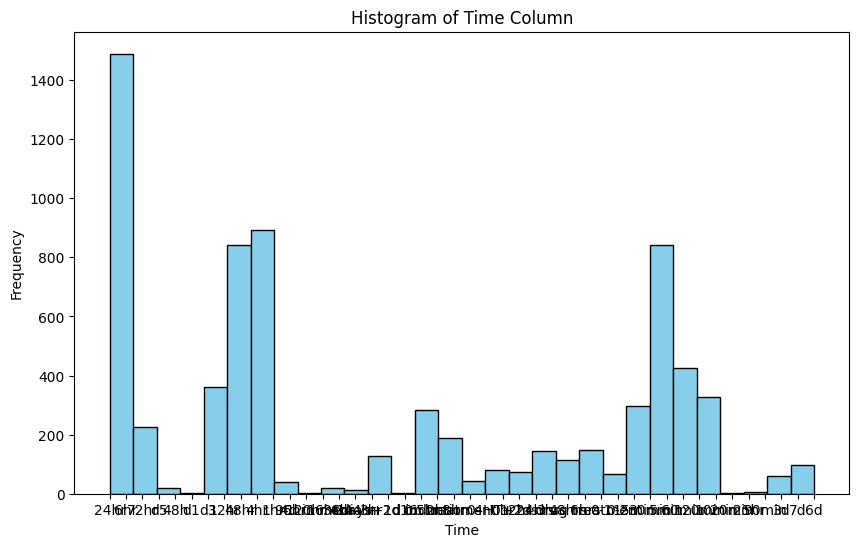

In [ ]:
dfs = []
non_readable = []
for i in tsv_files:
    try:
        df = pd.read_csv(i, sep='\t')
        dfs.append(df)
    except Exception as e:
        print(f"Could not read {i}: {e}")
        non_readable.append(i)

# Concatenate all DataFrames into one large table
large_table = pd.concat(dfs, ignore_index=True)


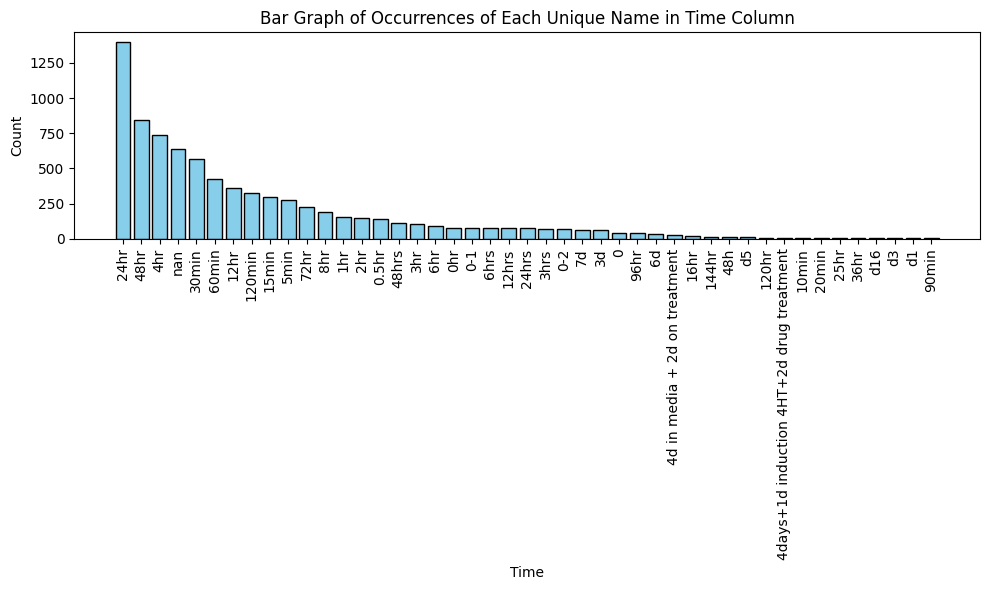

In [ ]:

import matplotlib.pyplot as plt

# Check if 'time' column exists
if 'time' in large_table.columns:
    time_counts = large_table['time'].value_counts(dropna=False)
    plt.figure(figsize=(10,6))
    plt.bar(time_counts.index.astype(str), time_counts.values, color='skyblue', edgecolor='black')
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.title('Bar Graph of Occurrences of Each Unique Name in Time Column')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("The 'time' column does not exist in the large_table DataFrame.")


In [ ]:

# Group rows so that those with the same values for all columns except UID, time, set, and resource are next to each other
exclude_cols = {'UID', 'time', 'set', 'resource'}
group_cols = [col for col in large_table.columns if col not in exclude_cols]
if group_cols:
    large_table = large_table.sort_values(by=group_cols).reset_index(drop=True)
    print(f"DataFrame indices reorganized to group rows by the same values in columns: {group_cols}")
    # To count the number of unique time courses:
    num_time_courses = large_table[group_cols].drop_duplicates().shape[0]
    print(f"Number of unique time courses: {num_time_courses}")
else:
    print("No columns available to group by after excluding UID, time, set, and resource.")



DataFrame indices reorganized to group rows by the same values in columns: ['cell_line_name', '2D_3D', 'stimuli', 'compound_name_1', 'dosage_1', 'compound_name_2', 'dosage_2', 'compound_name_3', 'dosage_3', 'compound_name_4', 'dosage_4']
Number of unique time courses: 2522
Number of unique time courses with more than one time point: 0
